# Import Packages.

NetCDF4 and xarray are not included by default in Anaconda, to install it open a cmd.exe teminal and use the the following command: 

conda install netcdf4

conda install xarray

In [18]:
## -*- coding: utf-8 -*-
#"""
#Created on Mon Mar 23 12:21:14 2020
#
#@author: lauri

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 



# Function 1: 10 year mean

In [19]:
def ten_year_mean(f):
    
    o3 = xr.open_dataset(f)
    
    dfo3 = o3.to_dataframe()    

    t_index_o3 = dfo3.reset_index(level=['bnds', 'latitude', 'longitude']) 
    
    o3_10Ymean_nocol = t_index_o3.groupby(['latitude', 'longitude', t_index_o3.index.month, t_index_o3.index.day, t_index_o3.index.hour]).o3_volume_mixing_ratio.mean()
    
    o3_10Ymean = o3_10Ymean_nocol.reset_index(level=[2, 3, 4, 'latitude', 'longitude'])
    
    o3_10Ymean.rename(columns={'level_2': 'month', 'level_3': 'day', 'level_4': 'hour', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True)
    
    return o3_10Ymean

# Function 2: AOT40

In [20]:
def AOT_forty_func(f):

    ppb_40 = np.full(len(f), 40)

    f['aot4'] = (f.o3_volume_mixing_ratio- ppb_40) 

    f[f < 0] = 0 
    
    AOT_sixteen_highest = f.groupby(['lat', 'lon', 'month','day'], as_index=False).apply(lambda x: x.nlargest(16, 'aot4'))

    AOT_sixteen_highest_sum = AOT_sixteen_highest.groupby(['lat', 'lon', 'month','day'], as_index=False).aot4.sum()    

    return AOT_sixteen_highest_sum



# Function 3: M16

In [21]:
def M16_func(f):

    sixteen_highest = f.groupby(['lat', 'lon', 'month','day'], as_index=False).apply(lambda x: x.nlargest(16, 'o3_volume_mixing_ratio'))

    sixteen_highest_mean = sixteen_highest.groupby(['lat', 'lon', 'month','day'], as_index=False).o3_volume_mixing_ratio.mean()

    sixteen_highest_mean.rename(columns={'o3_volume_mixing_ratio': 'mean_ozone'}, inplace=True)
    
    return sixteen_highest_mean

# Function 4: Visualisation



In [22]:
def visualise_monthly(f): 

    proj = ccrs.PlateCarree()  

    list_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

    for month in range(1 ,13): 

        sel_month_TenY_mean = TenY_mean_df[TenY_mean_df.month == month] 
        sel_month_M16 = M16_df[M16_df.month == month] 
        sel_month_AOT40 = AOT40df[AOT40df.month == month] 

        twodarray_TenY_mean =  sel_month_TenY_mean.pivot_table(index = 'lat', columns = 'lon', values = 'o3_volume_mixing_ratio', aggfunc=np.mean)
        twodarray_M16 =  sel_month_M16.pivot_table(index = 'lat', columns = 'lon', values = 'mean_ozone', aggfunc=np.mean)
        twodarray_AOT40 =  sel_month_AOT40.pivot_table(index = 'lat', columns = 'lon', values = 'aot4', aggfunc=np.mean)

        fig = plt.figure(figsize=(30, 8)) 

        axs1 = fig.add_subplot(1,3,1, projection = proj)
        axs2 = fig.add_subplot(1,3,2, projection = proj)
        axs3 = fig.add_subplot(1,3,3, projection = proj)

        im1 = axs1.pcolor(twodarray_TenY_mean.columns.values, twodarray_TenY_mean.index.values, twodarray_TenY_mean, vmin=0, vmax=90,cmap=plt.cm.jet)
        im2 = axs2.pcolor(twodarray_M16.columns.values, twodarray_M16.index.values, twodarray_M16,vmin=0, vmax=90,cmap=plt.cm.jet)
        im3 = axs3.pcolor(twodarray_AOT40.columns.values, twodarray_AOT40.index.values, twodarray_AOT40, vmin=0, vmax=700,cmap=plt.cm.jet)

        axs_title_list = [("Mean " + list_months[month-1] +" Decadal Avg (ppbV)"),("Mean " + list_months[month-1] +" M16 (ppbV)"),("Mean " + list_months[month-1]+ " AOT40 (daily sum 16 highest)(ppbV)")]


        for col in range(1,4):
            list_axs = [axs1, axs2, axs3] 
            list_im = [im1, im2, im3]
            ax = list_axs[col-1]
            ax.coastlines()
            ax.set_yticks(twodarray_TenY_mean.index.values)
            ax.set_xticks(twodarray_TenY_mean.columns.values)
            ax.set_title(axs_title_list[col-1],fontsize=20)
            ax.set_xlabel('$^\circ$Longitude',fontsize=20)
            ax.set_ylabel('$^\circ$Latitude',fontsize=20)
            ax.tick_params(labelsize=20)

            n=2
            for index, label in enumerate(ax.xaxis.get_ticklabels()):
                if index % n != 0:
                    label.set_visible(False)

            for index, label in enumerate(ax.yaxis.get_ticklabels()):
                if index % n != 0:
                    label.set_visible(False)

            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

            cb = fig.colorbar(list_im[col-1], ax=ax, fraction=0.041, pad=0.04)
    
        #file_path_figure = "------" #enter filepath where you want to save the figure here
        #plt.savefig(file_path_figure+list_months[month-1]+'.png') #option to save the figure as a .png
    plt.show()

# Call Functions and Visualise

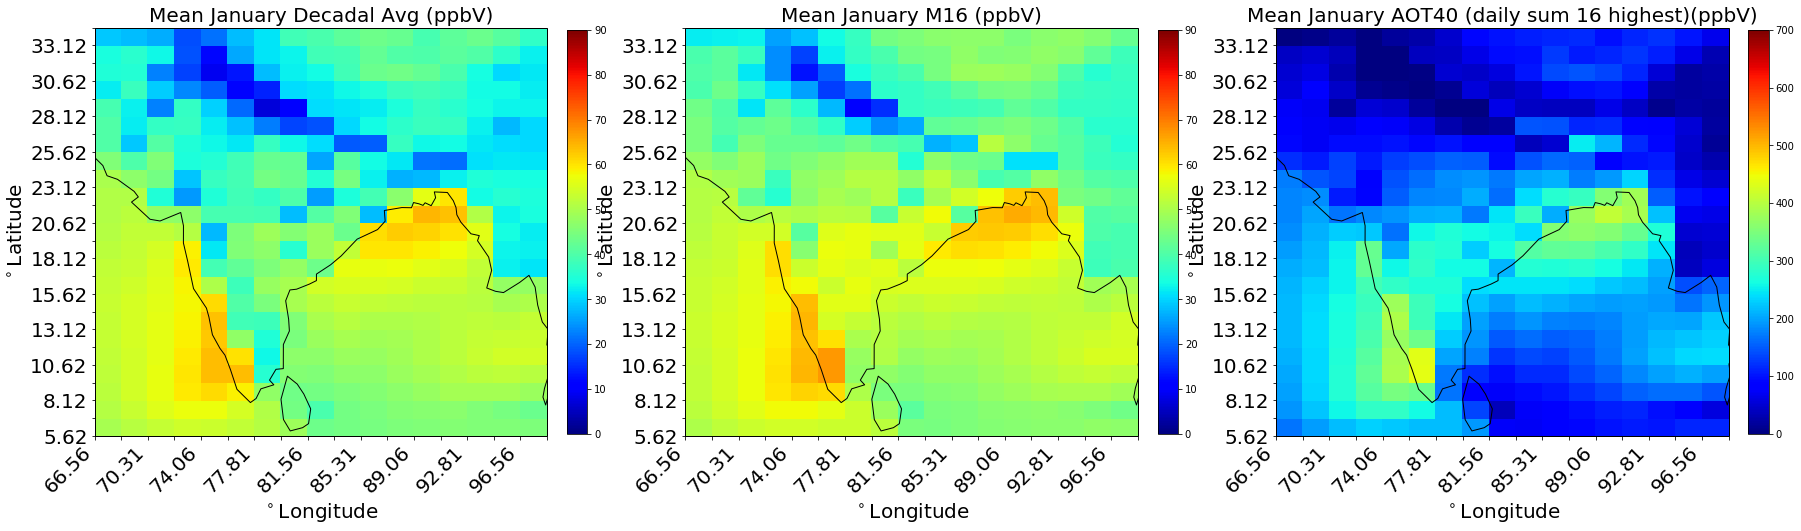

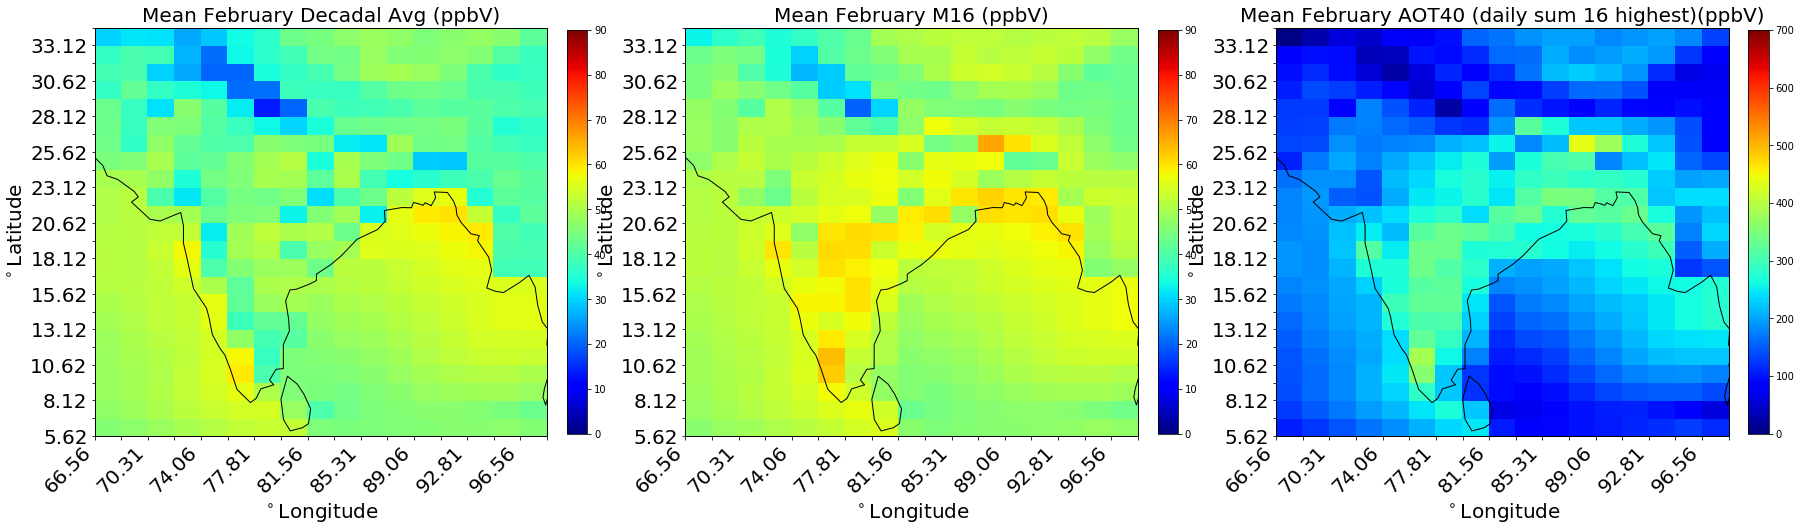

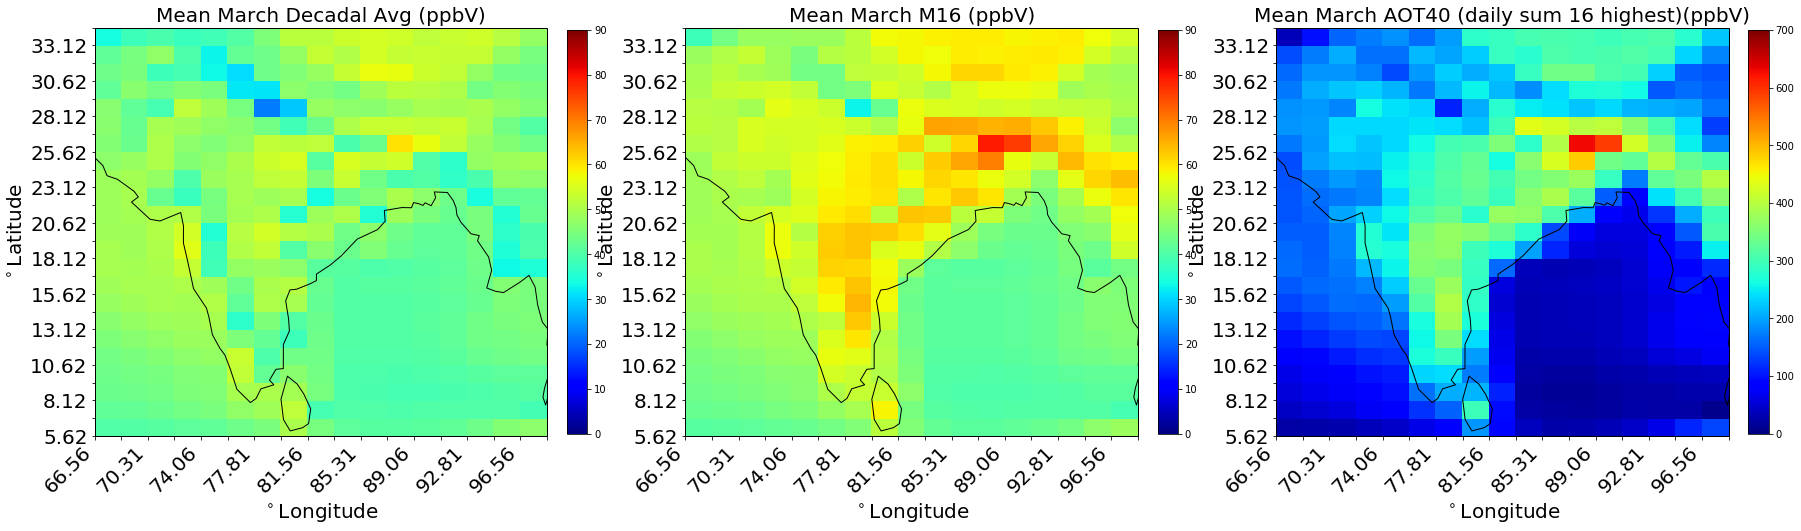

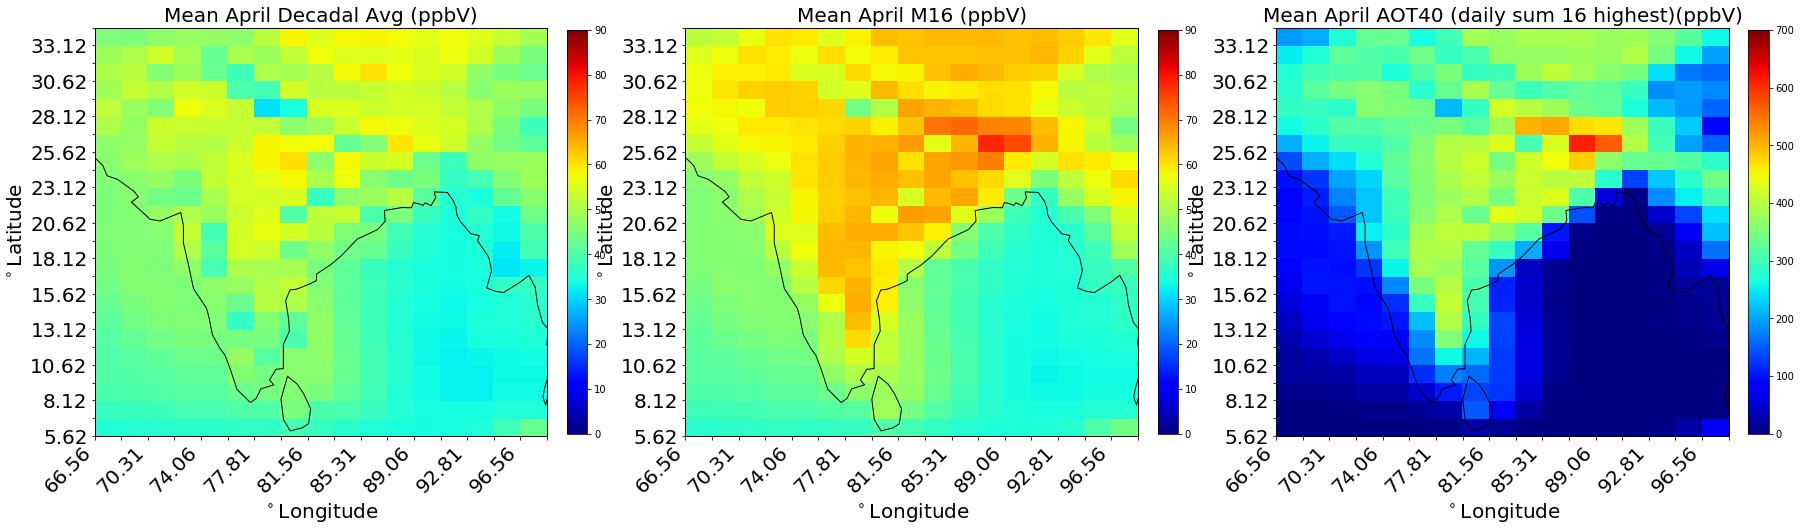

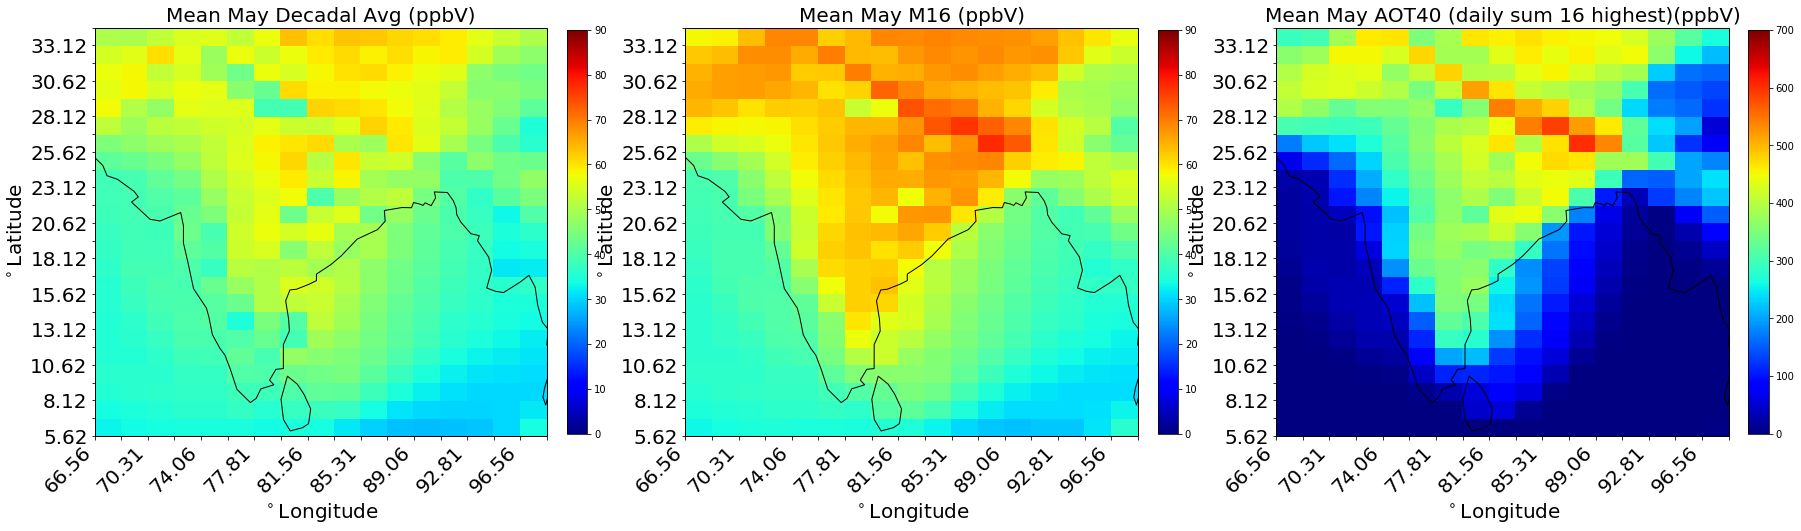

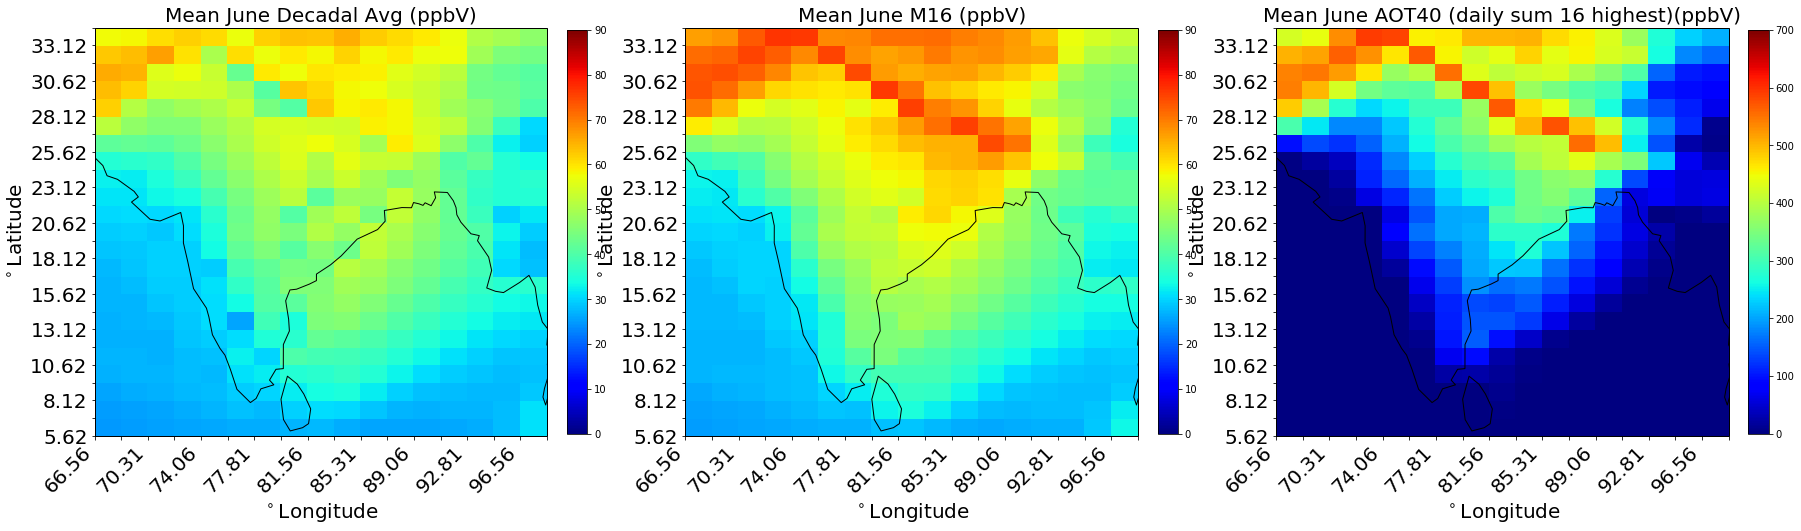

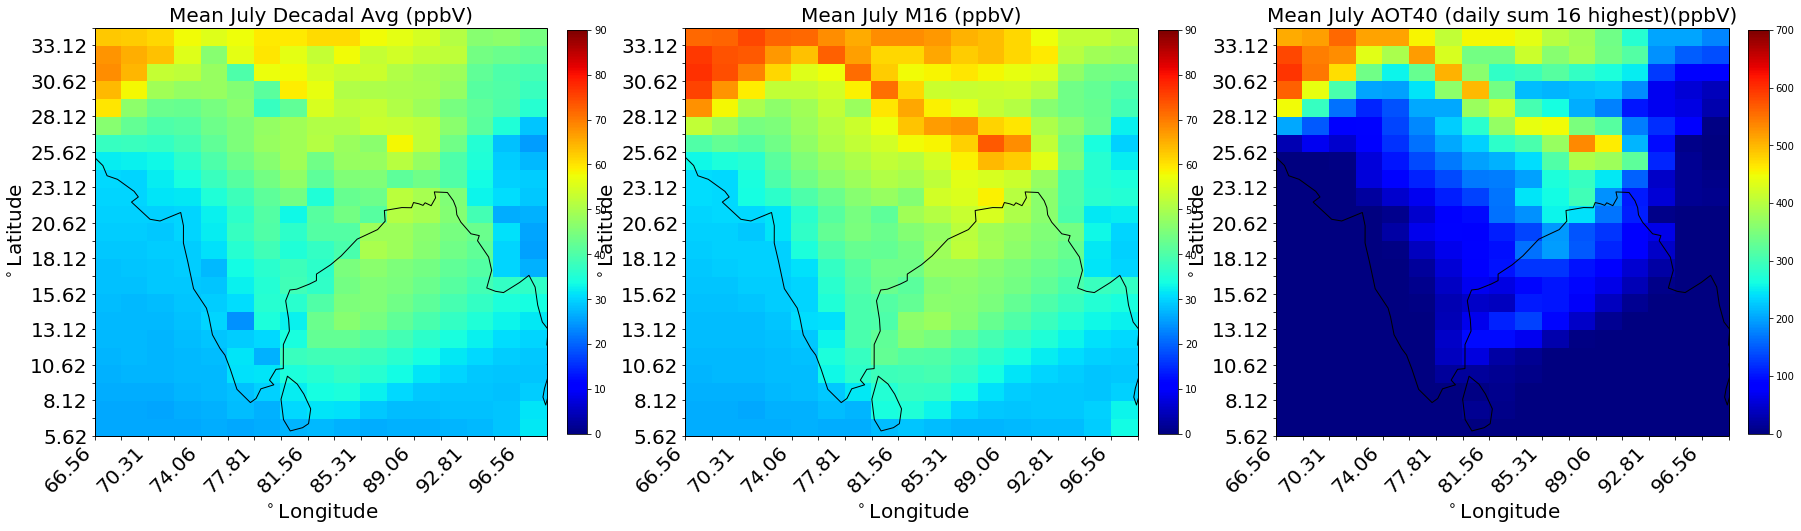

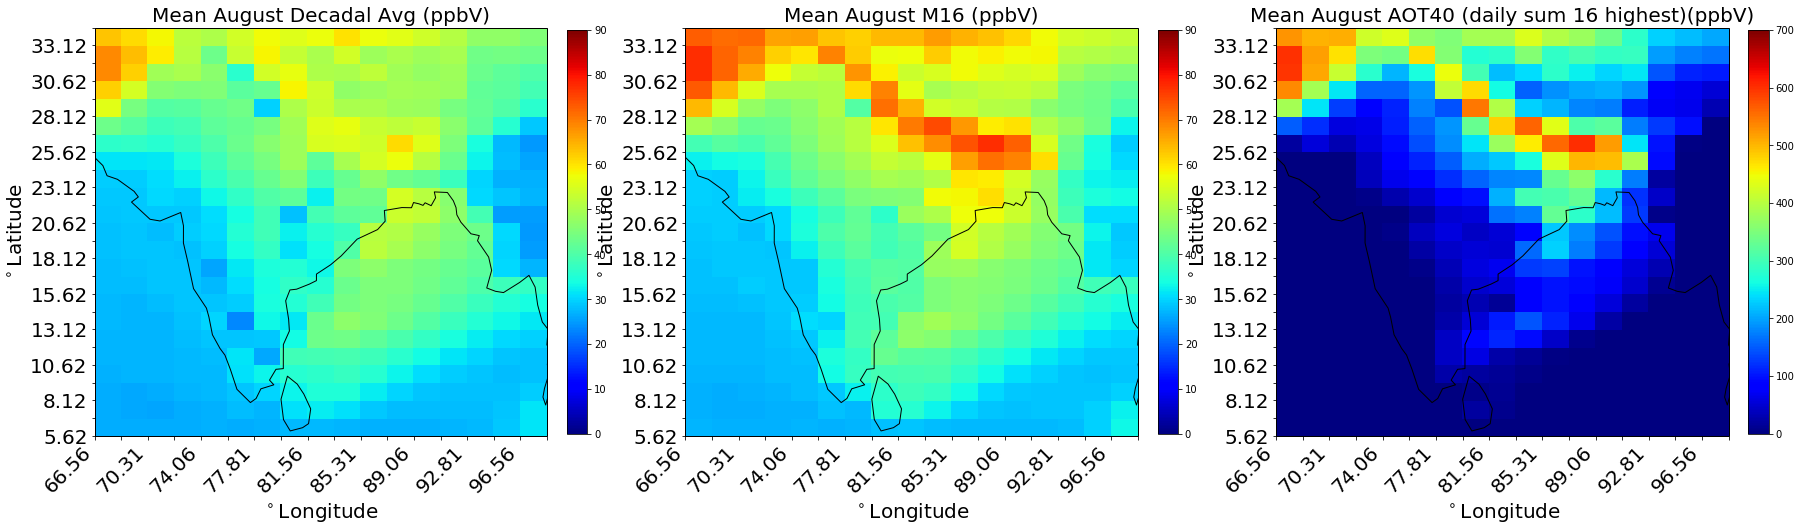

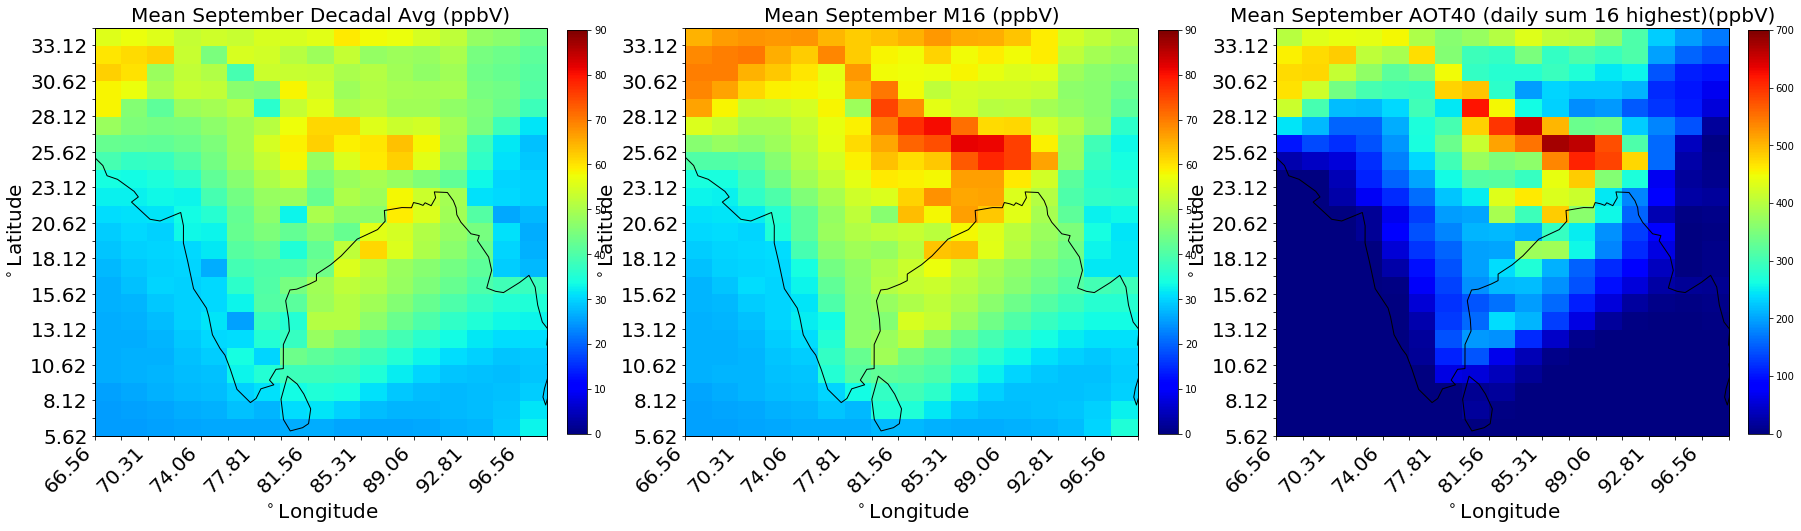

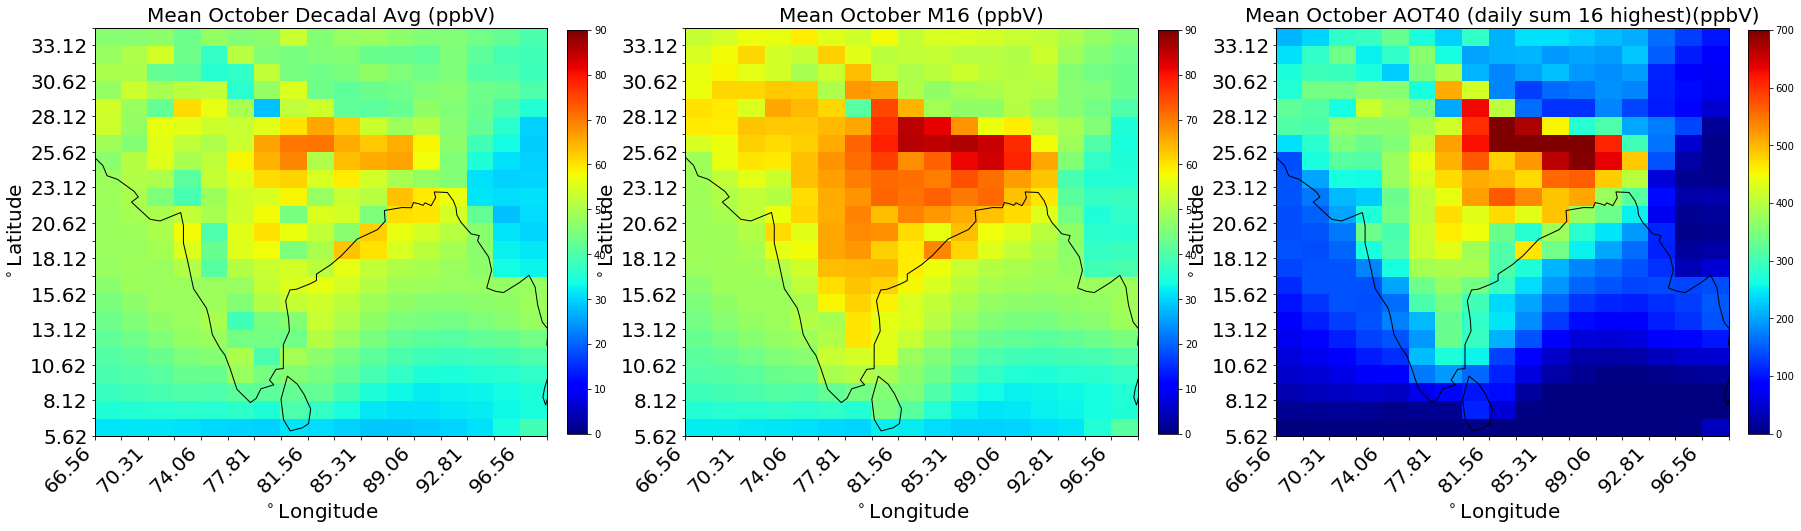

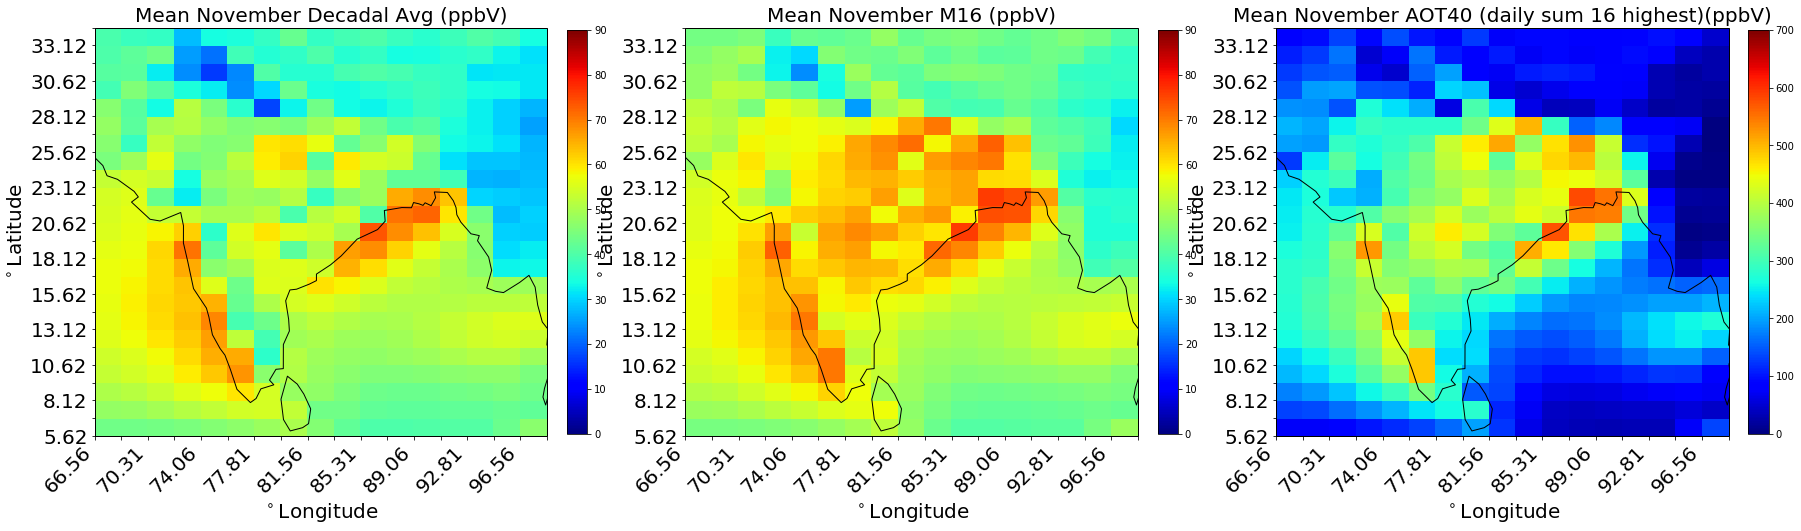

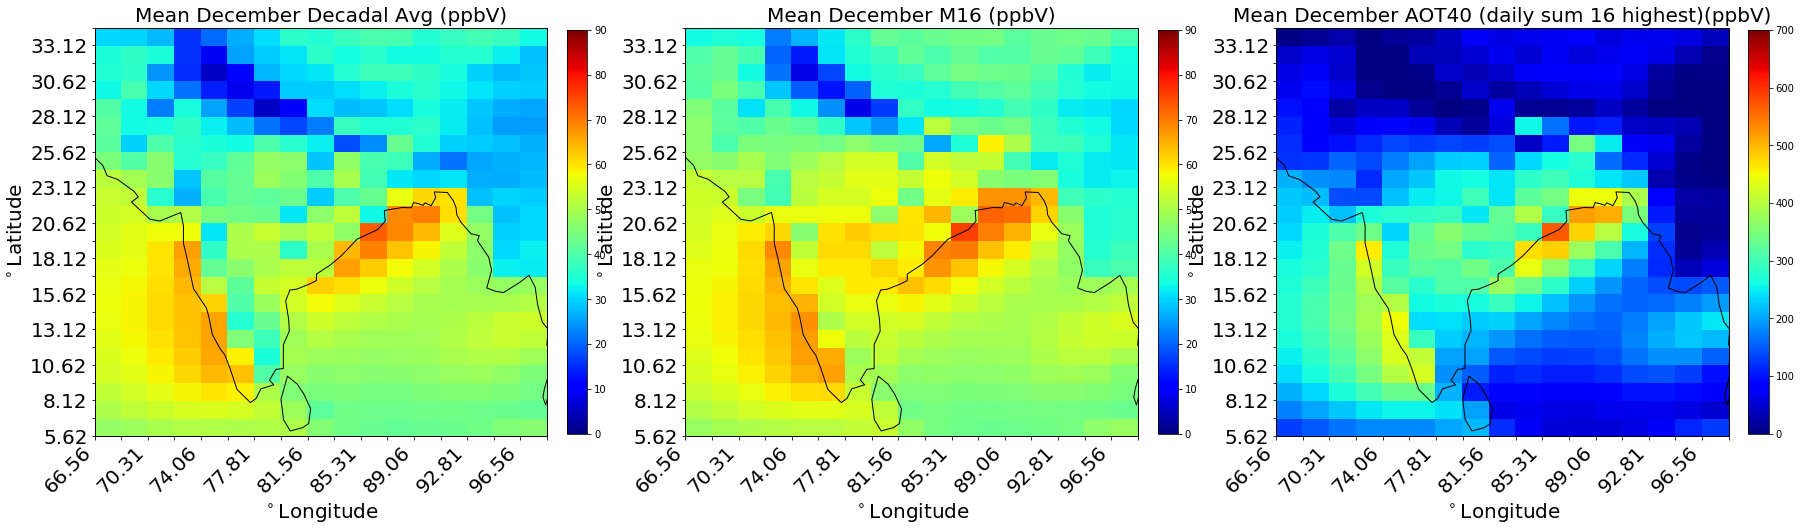

In [28]:
file_path = "C:\\Users\\lauri\\OneDrive\\Desktop\\SteveT_data\\ozone\\UKESM1_hourly_O3_volume_mixing_ratio_in_ssp126_for_2025_2035_India.nc" #insert the file path of the O3 concentration NetCDF file(s) 


#TenY_mean_df = ten_year_mean(file_path)

#AOT40df = AOT_forty_func(TenY_mean_df)
#M16_df = M16_func(TenY_mean_df)
list_varianbles = [TenY_mean_df, AOT40df, M16_df]
visualise_monthly(list_varianbles)


# Function 5.1 : Growing Season



In [ ]:


def growing_season(num_grid_cells) #the function takes the number of grid cells in your data as the argument
    
    day_gs =  list(range(300, 360)) + list(range(0, 300)) + list(range(360, 365)) #modify according to the growing season 
    
    j=0

    d_ord = [] #initialise an empty list 
    while j < num_grid_cells:
        for n in day_gs:
            n = n + (365 *j) #each day in the list day_gs has 365*j added to it, so that each grid cell will index 
            d_ord.append(n)


        j = j + 1
    
    return d_ord


In [ ]:
grid_cells = 432
day_order = growing_season(grid_cells)

In [ ]:
def data_reformatting(g):
    
    #This section creates 5 databases which copy the information at day 360 for every grid cell (i.e. once every 360 rows)
    #the numbers 1-5, creating days 361-365, are added to the time1 column, and 0.1-0.5 are added to the index for each grid gell. 
    #we need to add fractions to the index because otherwise when we come to combine these databases with the origional
    #the newly created 'extra day' dataframes would overwrite enteries in the original.
    df1 = (g.iloc[359::360]
             .assign(time = lambda x: x['time1'] + 1)
             .rename(lambda x: x + .1))

    df2 = (g.iloc[359::360]
             .assign(time = lambda x: x['time1'] + 2)
             .rename(lambda x: x + .2))

    df3 = (g.iloc[359::360]
             .assign(time = lambda x: x['time1'] + 3)
             .rename(lambda x: x + .3))

    df4 = (g.iloc[359::360]
             .assign(time = lambda x: x['time1'] + 4)
             .rename(lambda x: x + .4))

    df5 = (g.iloc[359::360]
             .assign(time = lambda x: x['time1'] + 5)
             .rename(lambda x: x + .5))

    AOTextraDays = pd.concat([g, df1, df2, df3, df4, df5], sort=False).sort_index().reset_index(drop=True)

    #Here, we change the order of the days through re-indexing to match the order corresponding to the growing season, 
    #which we have defined, this step is unnecassary if you dont need to do this.
    AOTextraDaysOrd = AOTextraDays.reindex(-----) #enter the variable name assigned to the output of function 5.1 
    
    n_grid_cells = ----- #enter number of grid cells here
    
    daynumber = 365*n_grid_cells
    
    AOTextraDaysOrd['time'] = daynumber #Create a column with the day number in order 1-365 for each cell.
    
    #the integers in timecolumn are converted to strings and the string days is added, this makes it possible to convert the
    #day number to timedelta objects, this format is needed for my model and makes futher datetime operations possible.
    AOTextraDaysOrd['time'] = AOTextraDaysOrd['time'].astype(str) + ' days'

    AOTextraDaysOrd['time'] = pd.to_timedelta(AOTextraDaysOrd['time'])
    
    AOTextraDaysOrd.drop(['month', 'day', 'time1'], axis=1, inplace=True) #drop unnecassary columns
    
    #move 'lat', 'lon' and 'time' to  the index so the data is one column with 3 dimensions
    AOTextraDaysOrd.set_index(['time','lat', 'lon'], inplace=True) 

    #First create xarray from pandas dataframe, (it is not possibe to create a netCDF from a pandas dataframe)
    xr_AOTextraDaysOrd = xr.Dataset.from_dataframe(AOTextraDaysOrd) 

    file_path = "-----" # enter where you to save the netCDF
    
    xr_AOTextraDaysOrd.to_netcdf(file_path)



    
    
